In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.8562663371533609, node: PEPTIDE1{H.G.A.C.R.L.F.C}$$$$
1- time: 0.03, count_rollouts: 2, reward: -0.9178556354175516, node: PEPTIDE1{Y.E.L.L.H.G.A.G.[dN].H.A.A.G.I.L.T.L.[am]}$$$$
2- time: 0.08, count_rollouts: 3, reward: -0.9301013973873944, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
3- time: 0.13, count_rollouts: 4, reward: -0.8734233480525885, node: PEPTIDE1{R.P.P.G.F.S.P.L.P.T.F}$$$$
4- time: 0.16, count_rollouts: 5, reward: -0.8078362434441901, node: PEPTIDE1{Y.V.[dP].D.V.V.G.[am]}$$$$
5- time: 0.18, count_rollouts: 6, reward: 0.9372522749834039, node: PEPTIDE1{G.R.G.G.L.R}$$$$
6- time: 0.20, count_rollouts: 7, reward: -0.8900652154916682, node: PEPTIDE1{F.T.S.E.I.K.R.A.K.[am]}$$$$
7- time: 0.23, count_rollouts: 8, reward: -0.8853578552997554, node: PEPTIDE1{A.P.R.E.R.R.R.K.K.R.[dV]}$$$$
8- time: 0.26, count_rollouts: 9, reward: -0.902801209433093, node: PEPTIDE1{T.P.R.E.R.R.R.K.A.R.G.[am]}$$

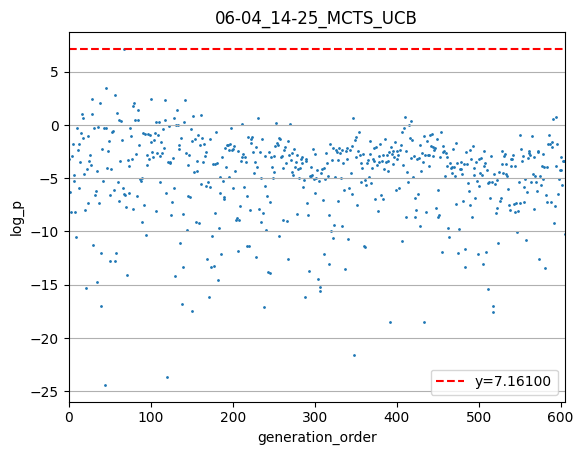

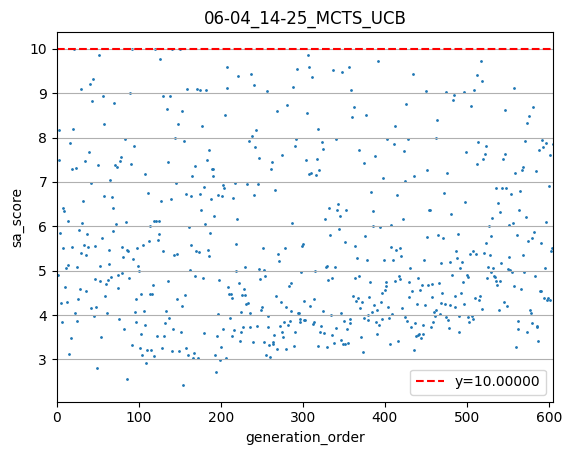

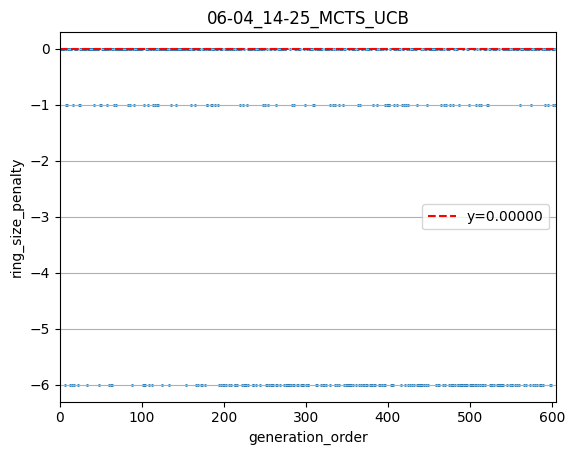

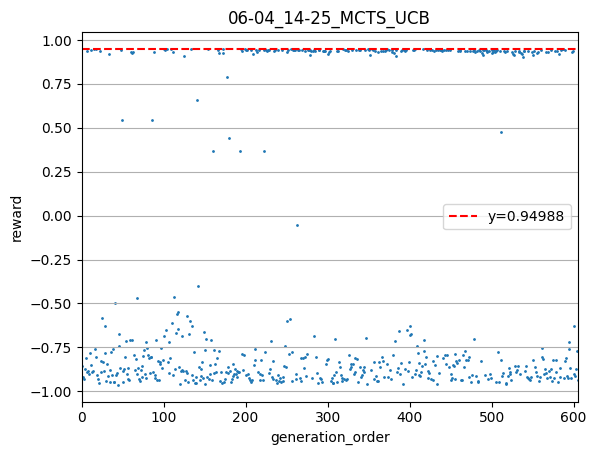

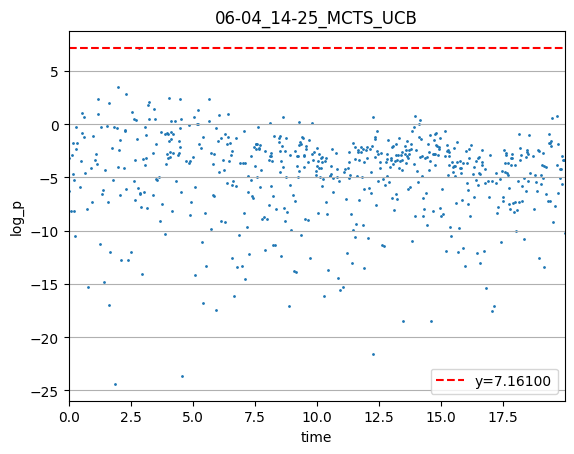

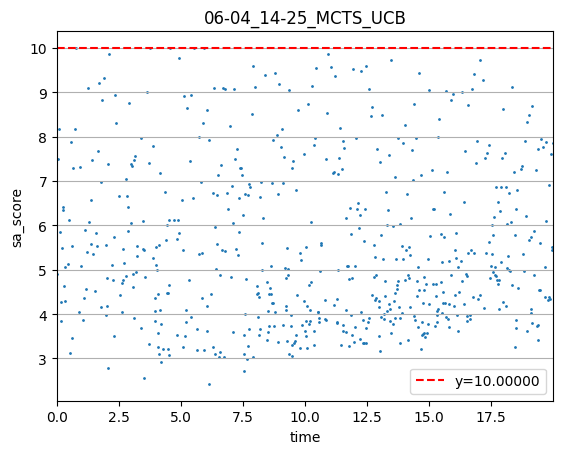

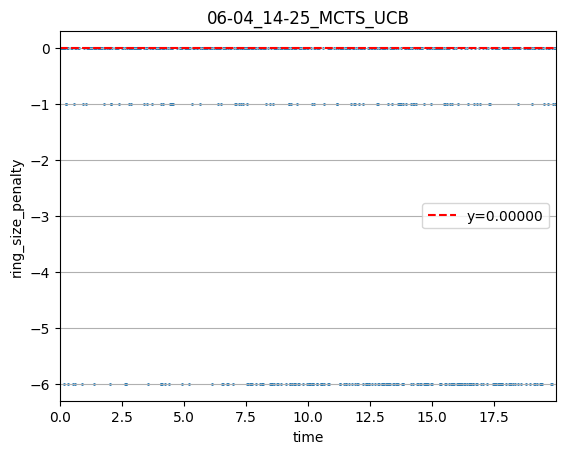

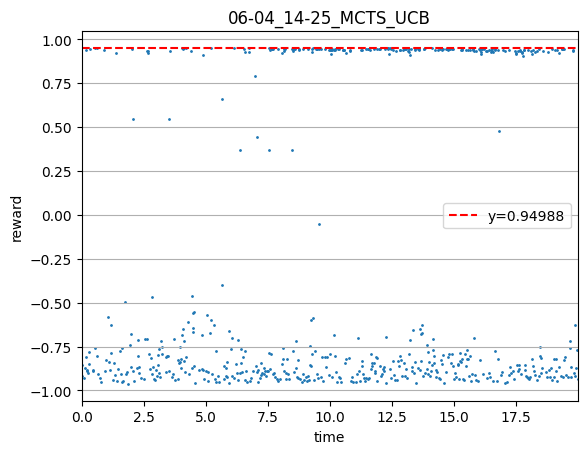

Search is completed.


In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)